<a href="https://colab.research.google.com/github/andrew-ryabchenko/DS-Unit-2-Kaggle-Challenge/blob/master/Kaggle_Challenge_DT_LR_Tuning_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders;

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from statistics import mean
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [ ]:
train_labels = pd.read_csv('https://raw.githubusercontent.com/andrew-ryabchenko/DS-Unit-2-Kaggle-Challenge/master/train_labels.csv')
train_features = pd.read_csv('https://raw.githubusercontent.com/andrew-ryabchenko/DS-Unit-2-Kaggle-Challenge/master/train_features.csv')
test_features = pd.read_csv('https://raw.githubusercontent.com/andrew-ryabchenko/DS-Unit-2-Kaggle-Challenge/master/test_features.csv')

In [ ]:
# dropping useless features

train_features_c = train_features.drop(columns=['wpt_name','num_private',
                                                'basin', 'region_code', 'district_code', 'lga', 'ward',
                                                'payment_type', 'quantity_group','source_type','waterpoint_type_group'])

test_features = test_features.drop(columns=['wpt_name','num_private',
                                                'basin', 'region_code', 'district_code', 'lga', 'ward',
                                                'payment_type', 'quantity_group','source_type','waterpoint_type_group'])

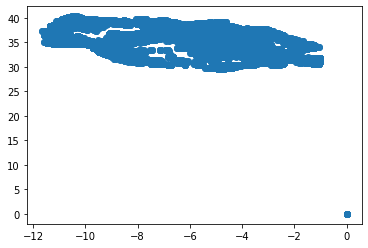

In [ ]:
plt.scatter(train_features_c['latitude'], train_features_c['longitude'])

In [ ]:
to_drop_in_target = train_features_c[~ (train_features_c['longitude'] == 0)].index
train_labels = train_labels.iloc[to_drop_in_target]

In [ ]:
train_features_c = train_features_c[~ (train_features_c['longitude'] == 0)]

In [ ]:
# drop high-cardinality features (nunique() > 20)

dtypes = pd.concat([train_features_c.nunique(), train_features_c.dtypes], axis=1)
cols_to_drop = dtypes[(dtypes[1] == 'object') & (dtypes[0] > 25)].index
train_features_c = train_features_c.drop(columns = [col for col in cols_to_drop])

dtypes = pd.concat([test_features.nunique(), test_features.dtypes], axis=1)
cols_to_drop = dtypes[(dtypes[1] == 'object') & (dtypes[0] > 25)].index
test_features = test_features.drop(columns = [col for col in cols_to_drop])

In [ ]:
train_features_c.describe()

,id,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,57588.00000,57588.000000,57588.000000,57588.000000,57588.000000,57588.000000,57588.000000
mean,37106.48807,327.645219,689.325137,35.149669,-5.885572,185.570831,1341.577360
std,21454.51421,3043.831403,693.564188,2.607428,2.809876,477.744239,937.641368
min,0.00000,0.000000,-90.000000,29.607122,-11.649440,0.000000,0.000000
25%,18522.75000,0.000000,0.000000,33.285100,-8.643841,0.000000,0.000000
50%,37054.50000,0.000000,426.000000,35.005943,-5.172704,35.000000,1988.000000
75%,55667.25000,30.000000,1332.000000,37.233712,-3.372824,230.000000,2004.000000
max,74247.00000,350000.000000,2770.000000,40.345193,-0.998464,30500.000000,2013.000000


In [ ]:
# impute missing values for predictor variables

imp = SimpleImputer(strategy = 'most_frequent')
train_features_c[['public_meeting','scheme_management','permit']] = imp.fit_transform(train_features_c[['public_meeting','scheme_management','permit']])

imp = SimpleImputer(strategy = 'most_frequent')
test_features[['public_meeting','scheme_management','permit']] = imp.fit_transform(test_features[['public_meeting','scheme_management','permit']])



In [ ]:
year_of_const = train_features_c[train_features_c['construction_year']>0]['construction_year']
population = train_features_c[train_features_c['population']>5]['population']

year_of_const_test = test_features[test_features['construction_year']>0]['construction_year']

In [ ]:
# impute 'construction_year' with the random values between 1990 and 2010

train_features_c['construction_year'] = train_features_c['construction_year'].apply(lambda x: np.random.randint(1990, high=2010) if x == 0 else x)

test_features['construction_year'] = test_features['construction_year'].apply(lambda x: np.random.randint(1990, high=2014) if x == 0 else x)

In [ ]:
# impute 'population' with the mean value

#train_features_c['population'] = train_features_c['population'].apply(lambda x: int(population.mean()) if x<5 else x)

In [ ]:
# Missing population values

#zero_pop_wards = pd.merge(left = train_features_c[train_features_c['population'] < 3][['id','population']],
                          #right = train_features[['id','ward']], on = 'id', how = 'left')

In [ ]:
# Create feature matrix and target vector

X = train_features_c.drop(columns=['id'])
y = train_labels['status_group']

In [ ]:
y.shape

(57588,)

In [ ]:
assert len(train_features_c) == len(train_labels), 'X and y are diffferent lenght'

In [ ]:
# Instantiate a pipeline for Logistic Regression Model

#model_lr = make_pipeline(
    #OneHotEncoder(use_cat_names=True),
    #StandardScaler(),
    #LogisticRegression()
#)

In [ ]:
# Instantiate a pipeline for Decision Tree Classifier 

model_dt = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

In [ ]:
# K-Fold cross validation. Estimate performance of the Logistic Regression model

#kfld = KFold(n_splits=10, shuffle=False)
#indices = kfld.split(train_features_c, train_labels)

#kfld_scores_lr = [] 

#for i in indices:
  #model_lr.fit(X.iloc[i[0]], y.iloc[i[0]])
  #kfld_scores_lr.append(model_lr.score(X.iloc[i[1]], y.iloc[i[1]]))

In [ ]:
#print(f'Log Reg cross validation avg score: {mean(kfld_scores_lr)}')

In [ ]:
# identify optimal max_depth for Decision tree

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)
scores = []
for i in range(5,25):
  model_dt.set_params(decisiontreeclassifier__max_depth=i)
  model_dt.fit(X_train, y_train)
  score = model_dt.score(X_test, y_test)
  scores.append((score,i))


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: Future

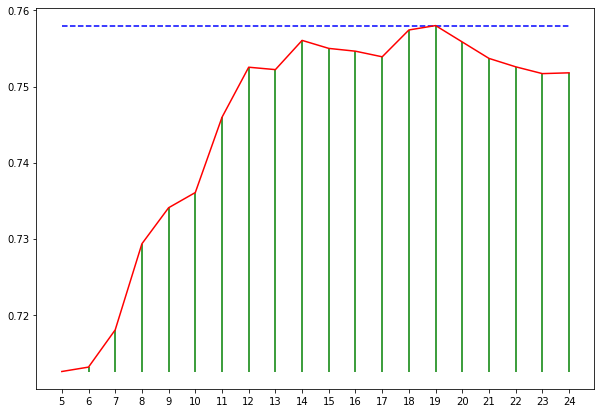

In [ ]:
fig, ax = plt.subplots()
ax.plot([depth[1] for depth in scores], [score[0] for score in scores], c ='r');
ax.vlines([depth[1] for depth in scores],min([score[0] for score in scores]),[score[0] for score in scores], colors= 'g')
ax.hlines(max([score[0] for score in scores]),min([depth[1] for depth in scores]),max([depth[1] for depth in scores]), colors= 'b', 
          linestyles='dashed')
ax.set_xticks([depth[1] for depth in scores])
fig.set_size_inches([10,7])
plt.show()

## Optimal *max_depth* = 19

In [ ]:
# Check K-Fold cross validation average score using optimal 'max_depth'

kfld = KFold(n_splits=10, shuffle=False)
indices = kfld.split(X, y)
model_dt.set_params(decisiontreeclassifier__max_depth=19)
kfld_scores_dt = [] 

for i in indices:
  model_dt.fit(X.iloc[i[0]], y.iloc[i[0]])
  kfld_scores_dt.append(model_dt.score(X.iloc[i[1]], y.iloc[i[1]]))

mean(kfld_scores_dt)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: Future

0.7637702130877981

## Decision Tree Model estimated accuracy = 0.77

In [ ]:
#create submission

predictions = model_dt.predict(test_features.drop(columns=['id']))
assert len(predictions) == len(test_features), 'Ooops, something went wrong...'

In [ ]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = predictions
submission.to_csv('kaggle_waterpump_challenge_submission_2.csv', index=False)